Created: 2020.07.20

Modified: 2020.07.28

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

import random
import pandas as pd
from pathlib import Path

import sys
sys.path.append('functions')
import functions32 as f32

# 2D AXIAL - T1

In [3]:
folder_path = Path('/data-10tb/shared/skull/axial-2d/')

df = pd.read_csv(folder_path/'t1_mask-test-val-axial-2d.csv')
print(df.shape)
df.head(3)

(425766, 6)


,root,t1_path,image_full_path,mask_full_path,usage_txt,usage
0,/data-10tb/shared/skull/axial-2d,/train/ADNI/ADNI_003_S_0931_MR_MPR-R__GradWarp...,/data-10tb/shared/skull/axial-2d/train/ADNI/AD...,/data-10tb/shared/skull/axial-2d/train/ADNI/AD...,train,False
1,/data-10tb/shared/skull/axial-2d,/train/ADNI/ADNI_003_S_0931_MR_MPR-R__GradWarp...,/data-10tb/shared/skull/axial-2d/train/ADNI/AD...,/data-10tb/shared/skull/axial-2d/train/ADNI/AD...,train,False
2,/data-10tb/shared/skull/axial-2d,/train/ADNI/ADNI_003_S_0931_MR_MPR-R__GradWarp...,/data-10tb/shared/skull/axial-2d/train/ADNI/AD...,/data-10tb/shared/skull/axial-2d/train/ADNI/AD...,train,False


#### Create DataBunch

In [4]:
# item list
il = SegmentationItemList.from_df(df, folder_path, cols='t1_path', convert_mode='L')

In [5]:
# split data
sd = il.split_from_df(col='usage')

In [6]:
codes = np.loadtxt(folder_path/'codes.txt', dtype=str); codes

array(['background', 'brain'], dtype='<U10')

In [7]:
# label list
ll = sd.label_from_df(cols='mask_full_path', classes=codes)

In [8]:
tmfs2 = get_transforms(do_flip=True, flip_vert=False,
                      max_rotate=15, max_zoom=1.05,
                      max_lighting=0.2, max_warp=None,
                      p_affine=0.5, p_lighting=0.5
                      )
bs=128
size = 128

In [9]:
ll = ll.transform(tmfs2, tfm_y=True, size=size, padding_mode='zeros', resize_method=ResizeMethod.PAD)

In [10]:
data = ll.databunch(bs=bs).normalize(imagenet_stats)

In [11]:
data.train_ds[0]

(Image (1, 128, 128), ImageSegment (1, 128, 128))

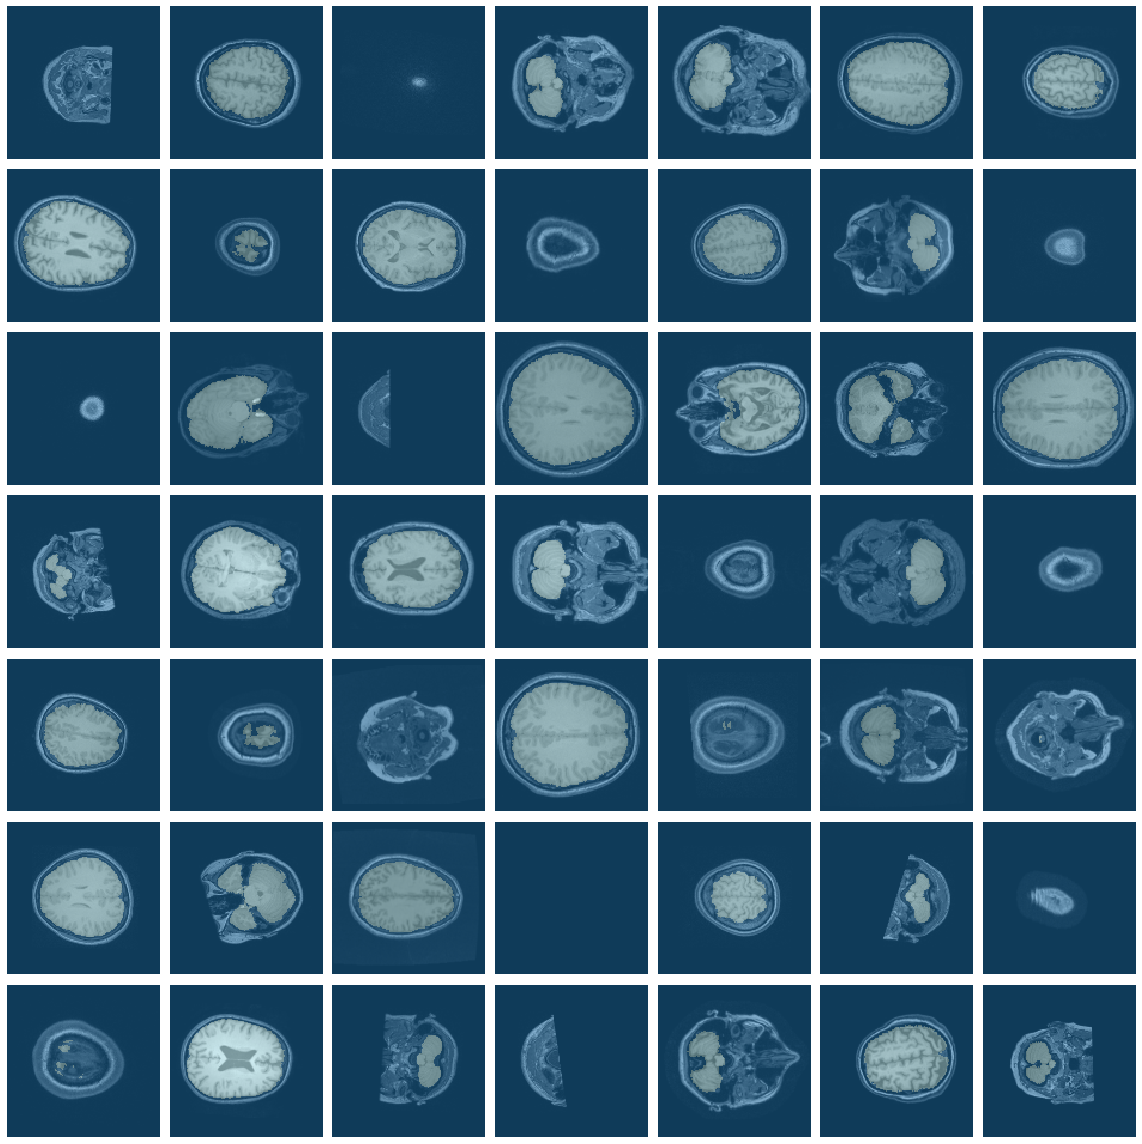

In [12]:
data.show_batch(7, figsize=(16,16))

In [13]:
# free = gpu_mem_get_free_no_cache()
# # the max size of bs depends on the available GPU RAM
# if free > 8200: bs=16
# else:           bs=8
# print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [14]:
wd=1e-2

In [15]:
learn = unet_learner(data, models.resnet34, metrics=dice, wd=wd)

epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 9.12E-04


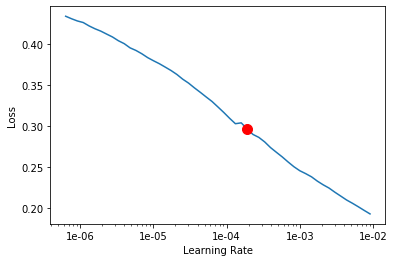

In [18]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

### LR=1e-3

In [16]:
lr=1e-3

In [20]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.023508,0.024333,0.929936,28:38
1,0.020234,0.022712,0.935030,24:14
2,0.017270,0.022786,0.937603,24:13
3,0.015413,0.022400,0.939433,24:09
4,0.014325,0.023973,0.940559,44:33


In [37]:
# id-trening-axial/freeze-unfreeze/fit-one-cycle-5/lr=1e-5/split-data
save = 0

sname = '3.02_01_train-axial_t1_fr_foc-05_lr-1e3_sp-all'
if save:
    learn.save(sname)

In [30]:
learn.load(sname);

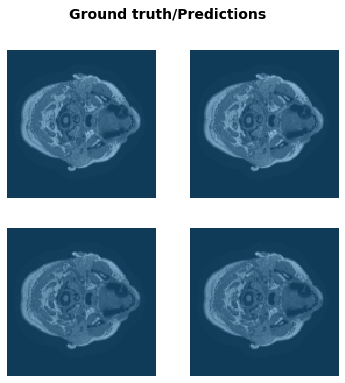

In [31]:
learn.show_results(rows=2, figsize=(6,6))

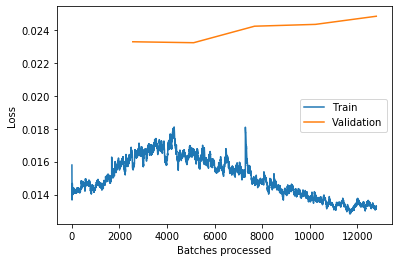

In [32]:
learn.recorder.plot_losses()

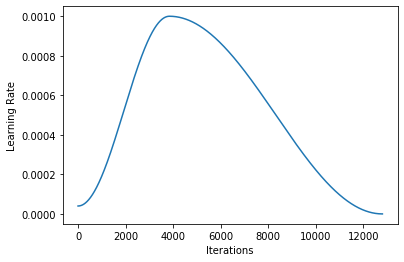

In [33]:
learn.recorder.plot_lr()

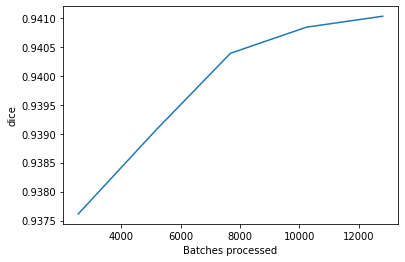

In [34]:
learn.recorder.plot_metrics()

In [35]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.014468,0.024021,0.939737,24:05
1,0.015361,0.025403,0.937592,24:11
2,0.014145,0.024900,0.939365,24:11
3,0.013166,0.026260,0.940831,24:11
4,0.012524,0.025645,0.941346,24:13


In [36]:
save = 0

sname = '3.02_02_train-axial_t1_fr_foc-10_lr-1e3_sp-all'
if save:
    learn.save(sname)

In [20]:
learn.load(sname);

In [21]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.013702,0.026485,0.940104,24:11
1,0.015461,0.024630,0.939138,24:11
2,0.013855,0.024132,0.940137,24:12
3,0.012903,0.025559,0.941620,24:12
4,0.012387,0.026539,0.941519,24:15


In [23]:
save = 0

sname = '3.02_03_train-axial_t1_fr_foc-15_lr-1e3_sp-all'
if save:
    learn.save(sname)

In [28]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.013325,0.024228,0.937706,24:03
1,0.015474,0.025551,0.938569,24:09
2,0.013324,0.025798,0.941317,24:10
3,0.012440,0.026484,0.941311,24:17
4,0.011850,0.027804,0.941209,24:18


In [30]:
save = 0

sname = '3.02_04_train-axial_t1_fr_foc-20_lr-1e3_sp-all'
if save:
    learn.save(sname)

In [38]:
learn.unfreeze()

In [39]:
lrs = slice(lr/5,lr/3)

In [40]:
learn.fit_one_cycle(5, lrs)

epoch,train_loss,valid_loss,dice,time
0,0.013029,0.025003,0.941325,25:21
1,0.013407,0.024673,0.940958,25:45
2,0.012958,0.025608,0.940986,25:41
3,0.012014,0.026681,0.942017,25:14
4,0.011549,0.028611,0.942254,25:10


In [42]:
save = 0

sname = '3.02_05_train-axial_t1_uf_foc-25_lr-1e3_sp-all'
if save:
    learn.save(sname)